# BME 548 Final Project

In [2]:
# Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold
from google.colab import files
import os
import matplotlib.image as mpimg
import copy
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix

## Data
[Instructions on how to download Kaggle data](https://www.kaggle.com/general/74235)

[Kaggle dataset 1](https://www.kaggle.com/zainaali/covid2019-dataset-with-chest-xray-images?)

[Kaggle dataset 2](https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia?)

In [3]:
!unzip "/content/drive/My Drive/BME548_Data/COVID_19_dataset1.zip"  # Both of the data sets are stored in Google Drive, unzip them
!unzip "/content/drive/My Drive/BME548_Data/COVID_19_dataset2.zip"  # This box takes a while to run :/

Streaming output truncated to the last 5000 lines.
  inflating: Data/train/COVID19/COVID19(229).jpg  
  inflating: Data/train/COVID19/COVID19(23).jpg  
  inflating: Data/train/COVID19/COVID19(230).jpg  
  inflating: Data/train/COVID19/COVID19(231).jpg  
  inflating: Data/train/COVID19/COVID19(232).jpg  
  inflating: Data/train/COVID19/COVID19(233).jpg  
  inflating: Data/train/COVID19/COVID19(234).jpg  
  inflating: Data/train/COVID19/COVID19(235).jpg  
  inflating: Data/train/COVID19/COVID19(236).jpg  
  inflating: Data/train/COVID19/COVID19(237).jpg  
  inflating: Data/train/COVID19/COVID19(238).jpg  
  inflating: Data/train/COVID19/COVID19(239).jpg  
  inflating: Data/train/COVID19/COVID19(24).jpg  
  inflating: Data/train/COVID19/COVID19(240).jpg  
  inflating: Data/train/COVID19/COVID19(241).jpg  
  inflating: Data/train/COVID19/COVID19(242).jpg  
  inflating: Data/train/COVID19/COVID19(243).jpg  
  inflating: Data/train/COVID19/COVID19(244).jpg  
  inflating: Data/train/COVID19/C

(485, 565, 3)

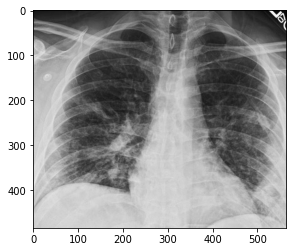

In [4]:
# Load the data to make sure it works
covid_im1 = Image.open("/content/Data/test/COVID19/COVID19(460).jpg")
covid_im2 = mpimg.imread("/content/TestImages/COVID-19/n_health_3.JPG")
plt.imshow(covid_im2)
np.shape(covid_im2)

In [5]:
directory = [None]*8
directory[0] = "/content/Data/test/COVID19"
directory[1] = "/content/Data/test/NORMAL"
directory[2] = "/content/Data/train/COVID19"
directory[3] = "/content/Data/train/NORMAL"
directory[4] = "/content/TestImages/COVID-19"
directory[5] = "/content/TestImages/Normal"
directory[6] = "/content/TrainImages/COVID-19"
directory[7] = "/content/TrainImages/Normal"

dimensions = (10000000000, 10000000000, 10000000000)
dims_list = list()
the_smallest = None
test_pos_ct = 0
train_pos_ct = 0
test_neg_ct = 0
train_neg_ct = 0
for ind, dir in enumerate(directory):
    for entry in os.listdir(dir):
        image = Image.open("{}/{}".format(dir, entry))
        shape = np.shape(image)
        dims_list.append(shape)
        if ind == 0 or ind == 4:
            test_pos_ct += 1
        elif ind == 1 or ind == 5:
            test_neg_ct += 1
        elif ind == 2 or ind == 6:
            train_pos_ct += 1
        elif ind == 3 or ind == 7:
            train_neg_ct += 1

In [6]:
print("Train\nCOVID Positive: {}\nCOVID Negative: {}\n\nTest\nCOVID Positive: {}\nCOVID Negative: {}".format(train_pos_ct, train_neg_ct, test_pos_ct, test_neg_ct))

Train
COVID Positive: 699
COVID Negative: 1555

Test
COVID Positive: 176
COVID Negative: 377


(1327.3092269326683, 1563.366583541147, 2.612041325258283)
(515.7806572103508, 563.3996961249688, 0.8412488814347612)
[ 160.          161.63769149  163.27538297 ... 4753.72461703 4755.36230851
 4757.        ]


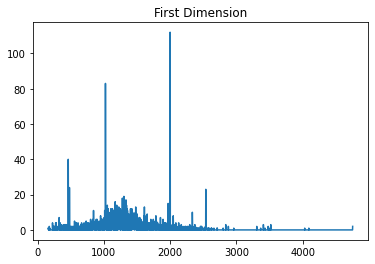

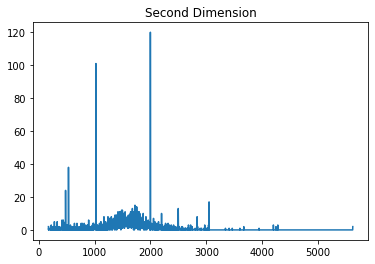

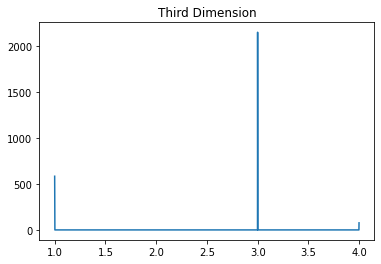

4

In [7]:
avg_1 = list()
avg_2 = list()
avg_3 = list()
for i in dims_list:
    avg_1.append(i[0])
    avg_2.append(i[1])
    try:
        avg_3.append(i[2])
    except IndexError:
        avg_3.append(1)
print((np.average(avg_1), np.average(avg_2), np.average(avg_3)))  # Average length in each dimension
print((np.std(avg_1), np.std(avg_2), np.std(avg_3)))  # Standard deviation of each dimension
hist_1, bins_1 = np.histogram(avg_1, bins=len(avg_1))
hist_2, bins_2 = np.histogram(avg_2, bins=len(avg_2))
hist_3, bins_3 = np.histogram(avg_3, bins=len(avg_3))
print(bins_1)
# plt.subplot(1, 3, 1)
plt.title("First Dimension")
plt.plot(bins_1[0:len(bins_1)-1], hist_1)
plt.show()

# plt.subplot(1, 3, 2)
plt.title("Second Dimension")
plt.plot(bins_2[0:len(bins_2)-1], hist_2)
plt.show()

# plt.subplot(1, 3, 3)
plt.title("Third Dimension")
plt.plot(bins_3[0:len(bins_3)-1], hist_3)
plt.show()

np.max(avg_3)

In [8]:
# Code for cropping the data
def im_crop(image, min_dimension):

    # plt.imshow(image)
    # plt.title("Original Image")
    # plt.show()

    the_shape = np.shape(image)
    big_dim = max(the_shape)  # Get the largest dimension
    other_dim = 0
    bd_index = 0
    od_index = 0
    if the_shape[0] == big_dim:
        bd_index = 0
        od_index = 1
        other_dim = the_shape[1]
    elif the_shape[1] == big_dim:
        bd_index = 1
        od_index = 0
        other_dim = the_shape[0]
    shave = big_dim - other_dim
    shave_1 = int(shave/2)  # You will shave this much and shave_2 from a side of the long dimension
    shave_2 = shave - shave_1  # Shaving allows the ratios of the image to be maintained, just resizing could distort
    if bd_index == 0:
        # image = image[shave_1:big_dim-shave_2, :, :]
        image = image.crop((0, shave_1+shave_2, other_dim, big_dim))  # Image.crop is left, top, right, bottom
        # Only shaves from the top, majority of COVID info is in the bottom of the lungs
    else:
        # image = image[:, shave_1:big_dim-shave_2, :]
        image = image.crop((shave_1, 0, big_dim-shave_2, other_dim))
    
    # plt.imshow(image)
    # plt.title("After Shaving")
    # plt.show()

    resized_image = image.resize((int(min_dimension), int(min_dimension)))
    # plt.imshow(resized_image)
    # plt.title("After Resizing")
    # plt.show()

    if len(the_shape) == 3:
        resized_image = np.sum(resized_image, axis=-1)
    
    # plt.imshow(resized_image)
    # plt.title("After summing")
    # plt.show()
    resized_image = np.asarray(resized_image)
    # Divide by the max, you forgot to do that
    resized_image = resized_image/resized_image.max()
    return resized_image


Text(0.5, 1.0, 'COVID-19 Image ')

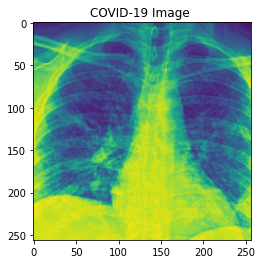

In [9]:
# Crop Data Test
dimension = 256  # Between the two average sizes of dimensions - was 1400, used way too much RAM
covid_im2 = Image.open("/content/TestImages/COVID-19/n_health_3.JPG")
new_covid_im2 = im_crop(covid_im2, dimension)
plt.imshow(new_covid_im2)
plt.title("COVID-19 Image ")

In [10]:
# Crop and Label all test, train, validation(?) data
# directory = [None]*8
# directory[0] = "/content/Data/test/COVID19"
# directory[1] = "/content/Data/test/NORMAL"
# directory[2] = "/content/Data/train/COVID19"
# directory[3] = "/content/Data/train/NORMAL"
# directory[4] = "/content/TestImages/COVID-19"
# directory[5] = "/content/TestImages/Normal"
# directory[6] = "/content/TrainImages/COVID-19"
# directory[7] = "/content/TrainImages/Normal"
test_dirs = [0, 1, 4, 5]  #indices in the directory list that correspond to the 
                          # test items, train items, and COVID +/- scans
train_dirs = [2, 3, 6, 7]
cov_pos_dirs = [0, 2, 4, 6]
cov_neg_dirs = [1, 3, 5, 7]

x_test = list()
y_test = list()
x_train = list()
y_train = list()
test_paths = list()
train_paths = list()
neg_train_indices = list()
neg_test_indices = list()

for index, dir in enumerate(directory):
    for entry in os.listdir(dir):
        image = Image.open("{}/{}".format(dir, entry))
        image = im_crop(image, dimension)
        if index == 0 or index == 1 or index == 4 or index == 5:  # Image should be in test
            x_test.append(image)
            test_paths.append("{}/{}".format(dir, entry))
            if index == 0 or index == 2 or index == 4 or index == 6:  # Image is COVID positive
                y_test.append(1)
            else:
                y_test.append(0)
                neg_test_indices.append(len(y_test) - 1)
        else:
            x_train.append(image)
            train_paths.append("{}/{}".format(dir, entry))
            if index == 0 or index == 2 or index == 4 or index == 6:  # Image is COVID positive
                y_train.append(1)
            else:
                y_train.append(0)
                neg_train_indices.append(len(y_train) - 1)


y_train_old = copy.deepcopy(y_train)

In [11]:
x_train = np.asarray(x_train)
y_tr = np.zeros((2254, 2))
for i, y in enumerate(y_train):
    if y == 0:
        y_tr[i, 0] = 1
    else:
        y_tr[i,1] = 1
y_train = y_tr

In [12]:
# Make the +/- splits 1:1
leave = False
to_remove_train = list()
to_remove_test = list()
# Remove enough from the training data
while leave is False:
    this_int = np.random.randint(0, high=len(neg_train_indices))
    if this_int not in to_remove_train:
        to_remove_train.append(this_int)
    if len(to_remove_train) == 856:
        leave = True

leave = False
# Remove enough from the testing data
while leave is False:
    this_int = np.random.randint(0, high=len(neg_test_indices))
    if this_int not in to_remove_test:
        to_remove_test.append(this_int)
    if len(to_remove_test) == 201:
        leave = True

In [13]:
remove_test = list()
remove_train = list()
for i in to_remove_test:
    remove_test.append(neg_test_indices[i])
for i in to_remove_train:
    remove_train.append(neg_train_indices[i])

In [14]:
small_x_train = np.delete(x_train, remove_train, 0)
small_y_train = np.delete(y_train, remove_train, 0)
new_train_paths = np.delete(train_paths, remove_train, 0)
# Also delete from the test and train path variables
small_x_test = np.delete(x_test, remove_test, 0)
small_y_test = np.delete(y_test, remove_test, 0)
new_test_paths = np.delete(test_paths, remove_test, 0)

In [15]:
print(len(remove_test))
print(len(remove_train))

201
856


In [16]:
print("Length of Original X Train: {}".format(len(x_train)))
print("Length of Equal X Train: {}".format(len(small_x_train)))
print("Number of COVID Negative in Original: {}".format(len(x_train)-np.sum(y_train_old)))
print("Number of COVID Negative in New: {}\n".format(np.sum(small_y_train[:, 1])))

print("Length of Original X Test: {}".format(len(x_test)))
print("Length of Equal X Test: {}".format(len(small_x_test)))
print("Number of COVID Negative in Original: {}".format(len(x_test)-np.sum(y_test)))
print("Number of COVID Negative in New: {}".format(np.sum(small_y_test)))

Length of Original X Train: 2254
Length of Equal X Train: 1398
Number of COVID Negative in Original: 1555
Number of COVID Negative in New: 699.0

Length of Original X Test: 553
Length of Equal X Test: 352
Number of COVID Negative in Original: 377
Number of COVID Negative in New: 176


In [17]:
x_train_not_shuffled = copy.deepcopy(small_x_train)
y_train_not_shuffled = copy.deepcopy(small_y_train)
# print(x_train.shape)
# print(y_train.shape)
new_indices = np.arange(1398)
np.random.shuffle(new_indices)
# print(new_indices)
x_train = small_x_train
y_train = small_y_train

x_test = small_x_test
y_test = small_y_test

for new, old in zip(new_indices, range(1398)):
    x_train[new, :, :] = x_train_not_shuffled[old, :, :]
    y_train[new, :] = y_train_not_shuffled[old, :]
x_val = x_train[1200:, :, :]
y_val = y_train[1200:, :]
x_train = x_train[0:1200, :, :]
y_train = y_train[0:1200, :]
# print(x_train.shape)
# print(x_val.shape)
x_train = np.resize(x_train, (1200, 256, 256, 1))
x_val = np.resize(x_val, (198, 256, 256, 1))
x_test = np.resize(x_test, (352, 256, 256, 1))
# print(x_train)
# print(y_train)

In [16]:
"""
ONLY RUN IF YOU WANT 
TO RESET TO THE BEGINNING 
OF THE LAST CELL
"""
x_train = x_train_not_shuffled
y_train = y_train_not_shuffled

(352, 256, 256, 1)
(1200, 256, 256, 1)
(352,)
(1200, 2)


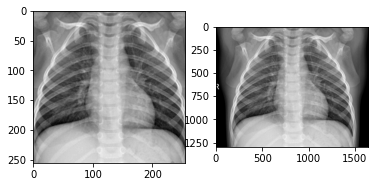

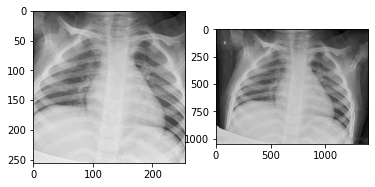

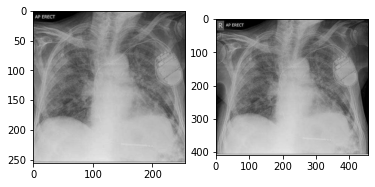

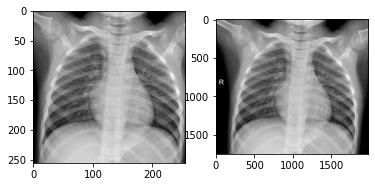

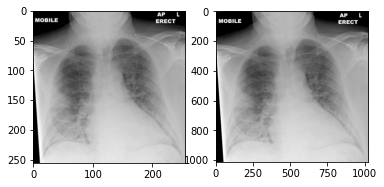

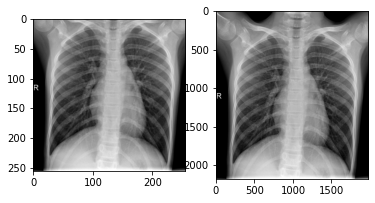

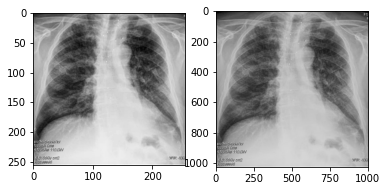

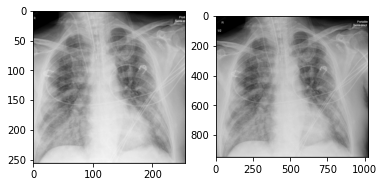

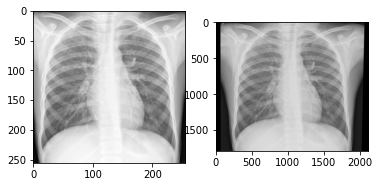

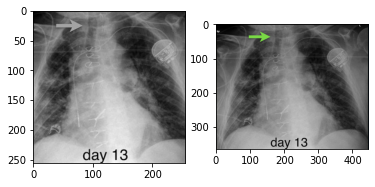

In [18]:
# Check data, make sure you aren't losing any valuable information
print(np.shape(x_test))
print(np.shape(x_train))
print(np.shape(y_test))
print(np.shape(y_train))

rand_pics = np.random.randint(0, high=352, size=10)
for address in rand_pics:
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[address][:,:,0], cmap="gray")
    plt.subplot(1, 2, 2)
    test_im = Image.open(new_test_paths[address])
    plt.imshow(test_im, cmap="gray")
    plt.show()

## Altering the Data
* Flip horizontally
* Allow for rotation (Maybe 20$^\circ$-30$^\circ$)

In [19]:
# Alter the data
mod_data = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, 
                                                           rotation_range=15)
mod_data.fit(x_train)  # Modify where x_train is COVID negative?  

## Designing the Model
* Use framework from --
* Add a layer at the beginning to represent a thin layer that stops some proportion of X-rays
    * tf.keras.constraints.MinMaxNorm(
    min_value=0.0, max_value=1.0, rate=1.0, axis=0
)


In [20]:
class phys_layer(tf.keras.layers.Layer):
    def __init__(self):
        super(phys_layer, self).__init__()  # Fairly certain that this was only used in HW3
                            # b/c it was overwriting Conv2D, but whatever
        input_shape = (256,256)
        # init = tf.ones(input_shape)
        # self.layer = tf.Variable(initial_value=init, 
        #                     trainable=True,
        #                     shape=input_shape,
        #                     dtype=tf.float32,
        #                     constraint=lambda z: tf.clip_by_value(z, 
        #                                                         clip_value_min=0, 
        #                                                         clip_value_max=1))
    def build(self, input_shape):#, input_shape=(256,256)):
        # Batch_size, height, width, first layer so no need for filters
        mod_in_shape = np.shape(input_shape)
        init = tf.ones((256,256,1))  # np.random.rand(256,256,1) 
        tf.convert_to_tensor(init)
        self.layer = tf.Variable(initial_value=init, 
                                 trainable=True,
                                 shape=(256,256,1),#input_shape,
                                 dtype=tf.float32,
                                 constraint=lambda z: tf.clip_by_value(z, 
                                                                       clip_value_min=0, 
                                                                       clip_value_max=1))
    
    def call(self, input):
        phys_layer_3 = tf.keras.layers.concatenate([self.layer, self.layer, self.layer], axis=-1)
        x = input*phys_layer_3
        return x

In [21]:
# It does work
input_lay = tf.keras.layers.Input((256, 256, 3))
x = phys_layer()(input_lay)

In [61]:
# Building the physical layer
# test = phys_layer()
# test.build((256, 256))
# plt.subplot(1, 3, 1)
# plt.imshow(test.layer.numpy()[0])
# plt.title("Initial Layer")

# test_in = tf.random.normal((256,256), mean=0.0, stddev=1)
# plt.subplot(1, 3, 2)
# plt.imshow(test_in.numpy())
# plt.title("Test Random Input")

# plt.subplot(1, 3, 3)
# plt.imshow(test.call(test_in))
# plt.title("Calling the Physical \nLayer on the \nRandom Input")
# plt.show()


# InceptionV3 Source Code
* Source: https://github.com/keras-team/keras-applications/blob/master/keras_applications/inception_v3.py

* I'm going to add my physical layer in here at the beginning

* get_submodules_from_kwargs: https://github.com/keras-team/keras-applications/blob/master/keras_applications/__init__.py

* decode_predictions and _obtain_input_shape: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py

* https://github.com/keras-team/keras-applications/tree/master/keras_applications

* Importing backend, layers, models from keras: https://github.com/keras-team/keras-applications/blob/bc89834ed36935ab4a4994446e34ff81c0d8e1b7/tests/applications_test.py


In [22]:
from keras import backend
from keras import layers
from keras import models
from keras import utils

kwargs = {}
kwargs['backend'] = backend
kwargs['layers'] = layers
kwargs['models'] = models
kwargs['utils'] = utils

_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None

backend_ = backend

def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils

def decode_predictions(preds, top=5, **kwargs):
    """Decodes the prediction of an ImageNet model.
    # Arguments
        preds: Numpy tensor encoding a batch of predictions.
        top: Integer, how many top-guesses to return.
    # Returns
        A list of lists of top class prediction tuples
        `(class_name, class_description, score)`.
        One list of tuples per sample in batch input.
    # Raises
        ValueError: In case of invalid shape of the `pred` array
            (must be 2D).
    """
    global CLASS_INDEX

    backend, _, _, keras_utils = get_submodules_from_kwargs(kwargs)

    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = keras_utils.get_file(
            'imagenet_class_index.json',
            CLASS_INDEX_PATH,
            cache_subdir='models',
            file_hash='c2c37ea517e94d9795004a39431a14cb')
        with open(fpath) as f:
            CLASS_INDEX = json.load(f)
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results


def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    """Internal utility to compute/validate a model's input shape.
    # Arguments
        input_shape: Either None (will return the default network input shape),
            or a user-provided shape to be validated.
        default_size: Default input width/height for the model.
        min_size: Minimum input width/height accepted by the model.
        data_format: Image data format to use.
        require_flatten: Whether the model is expected to
            be linked to a classifier via a Flatten layer.
        weights: One of `None` (random initialization)
            or 'imagenet' (pre-training on ImageNet).
            If weights='imagenet' input channels must be equal to 3.
    # Returns
        An integer shape tuple (may include None entries).
    # Raises
        ValueError: In case of invalid argument values.
    """
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape

In [23]:
"""Inception V3 model for Keras.
Note that the input image format for this model is different than for
the VGG16 and ResNet models (299x299 instead of 224x224),
and that the input preprocessing function is also different (same as Xception).
# Reference
- [Rethinking the Inception Architecture for Computer Vision](
    http://arxiv.org/abs/1512.00567) (CVPR 2016)
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

# from . import get_submodules_from_kwargs
# from . import imagenet_utils  # I think that this is a file that holds the 2 functions below this
# from .imagenet_utils import decode_predictions
# from .imagenet_utils import _obtain_input_shape


WEIGHTS_PATH = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = (
    'https://github.com/fchollet/deep-learning-models/'
    'releases/download/v0.5/'
    'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# backend = None
# layers = None
# models = None
# keras_utils = None


def conv2d_bn(x,
              filters,
              num_row,
              num_col,
              padding='same',
              strides=(1, 1),
              name=None):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    if backend_.image_data_format() == 'channels_first':  # CHANGE backend to backend_
        bn_axis = 1
    else:
        bn_axis = 3
    x = layers.Conv2D(
        filters, (num_row, num_col),
        strides=strides,
        padding=padding,
        use_bias=False,
        name=conv_name)(x)
    x = layers.BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = layers.Activation('relu', name=name)(x)
    return x


def my_InceptionV3(include_top=True,
                weights='imagenet',
                input_tensor=None,
                input_shape=None,
                pooling=None,
                classes=1000,
                **kwargs):
    """Instantiates the Inception v3 architecture.
    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)` (with `channels_last` data format)
            or `(3, 299, 299)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 75.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    #global backend, layers, models, keras_utils
    _no_backend, _no_layers, _no_models, _no_keras_utils = get_submodules_from_kwargs(kwargs)

    ### Replaces function of get_submodules_from_kwargs
    kwargs = {}
    kwargs['backend'] = backend
    kwargs['layers'] = layers
    kwargs['models'] = models
    kwargs['utils'] = utils
    backend_ = kwargs.get('backend', _KERAS_BACKEND)  # kwargs["backend"]  # CHANGE backend to backend_
    layers_ = kwargs.get('layers', _KERAS_LAYERS)  # kwargs["layers"]
    models_ = kwargs.get('models', _KERAS_MODELS)  # kwargs["models"]
    keras_utils = kwargs.get('utils', _KERAS_UTILS)  # kwargs["utils"]  

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=75,
        data_format=backend_.image_data_format(),
        require_flatten=include_top,
        weights=weights)

    if input_tensor is None:
        img_input = layers_.Input(shape=input_shape)
    else:
        if not backend_.is_keras_tensor(input_tensor):  # CHANGE backend to backend_
            img_input = layers_.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if backend_.image_data_format() == 'channels_first':  # CHANGE backend to backend_
        channel_axis = 1
    else:
        channel_axis = 3
    ### MY PHYSICAL LAYER BEGINS
    #init = tf.ones((256,256))# tf.ones(input_shape) # Maybe just height and width?
    img_input = phys_layer()(img_input)
    ### MY PHYSICAL LAYER ENDS
    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = layers_.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = layers_.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0: 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers_.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers_.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers_.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers_.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = layers_.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers_.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(
        branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers_.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers_.concatenate(
        [branch3x3, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers_.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers_.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = layers_.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers_.concatenate(
            [branch1x1, branch7x7, branch7x7dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = layers_.AveragePooling2D((3, 3),
                                          strides=(1, 1),
                                          padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers_.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(
        branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = layers_.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers_.concatenate(
        [branch3x3, branch7x7x3, branch_pool],
        axis=channel_axis,
        name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers_.concatenate(
            [branch3x3_1, branch3x3_2],
            axis=channel_axis,
            name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers_.concatenate(
            [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

        branch_pool = layers_.AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers_.concatenate(
            [branch1x1, branch3x3, branch3x3dbl, branch_pool],
            axis=channel_axis,
            name='mixed' + str(9 + i))
    if include_top:
        # Classification block
        x = layers_.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers_.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers_.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers_.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='inception_v3')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = keras_utils.get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                file_hash='9a0d58056eeedaa3f26cb7ebd46da564')
        else:
            weights_path = keras_utils.get_file(
                'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                file_hash='bcbd6486424b2319ff4ef7d526e38f63')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def preprocess_input(x, **kwargs):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Preprocessed array.
    """
    return imagenet_utils.preprocess_input(x, mode='tf', **kwargs)

In [24]:
# Designing the Model
image_shape=(256, 256, 1) #Change to whatever shapes you choose
def phys_model(image_size, phys=False):
    #model = tf.keras.models.Sequential()
    input_layer = tf.keras.layers.Input(image_size)
    x = input_layer
    if phys is True:
        pl = phys_layer()
        pl.build(image_size)
        x = pl.call(x)
    x = tf.keras.layers.concatenate([x, x, x], axis=-1)
    new_shape = []
    for i in image_size:
        new_shape.append(i)
    new_shape[-1] = 3
    new_shape = tuple(new_shape)
    model = tf.keras.applications.InceptionV3(include_top=True, 
                                              weights=None, 
                                              input_shape=new_shape, 
                                              input_tensor=input_layer,  # x
                                              classes=2)
    return model

def my_inception_v3_model(image_size):
    input_layer = tf.keras.layers.Input(image_size)
    x = input_layer
    """
    Missing the physical layer because now it's handled in my_InceptionV3
    """
    x = tf.keras.layers.concatenate([x, x, x], axis=-1)
    new_shape = []
    for i in image_size:
        new_shape.append(i)
    new_shape[-1] = 3
    new_shape = tuple(new_shape)
    model = my_InceptionV3(include_top=True, 
                           weights=None, 
                           input_shape=new_shape, 
                           input_tensor=x,  # input_layer,
                           classes=2)
    return model

In [65]:
test_mod = phys_model(image_shape, phys=False)
test_mod_2 = my_inception_v3_model(image_shape)

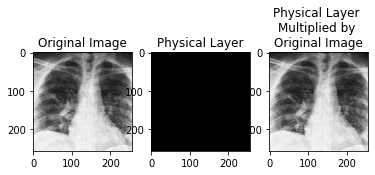

In [66]:
# Visualize Physical Layer Before Training
plt.subplot(1, 3, 1)
plt.imshow(new_covid_im2, cmap="gray")
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(test_mod_2.layers[2].get_weights()[0][:, :, 0], cmap="gray")
pl_before_train = test_mod_2.layers[2].get_weights()[0][:, :, 0]
plt.title("Physical Layer")
plt.subplot(1, 3, 3)
plt.imshow(new_covid_im2*test_mod_2.layers[2].get_weights()[0][:, :, 0], cmap="gray")
plt.title("Physical Layer \nMultiplied by \nOriginal Image")
plt.show()

In [54]:
# test_mod.summary()
test_mod_2.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 256, 256, 3)  0           input_7[0][0]                    
                                                                 input_7[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
phys_layer_3 (phys_layer)       (None, 256, 256, 3)  65536       concatenate_15[0][0]             
_______________________________________________________________________________________

In [67]:
# Train the model
opt = tf.keras.optimizers.SGD(learning_rate=0.85)
test_mod_2.compile(loss="categorical_crossentropy", 
                 metrics=['acc'], 
                 optimizer=opt)
# loss_and_acc = test_mod_2.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), validation_batch_size=32)
loss_and_acc = test_mod_2.fit(mod_data.flow(x_train, y_train, batch_size=32), epochs=50, validation_data=(x_val, y_val), validation_batch_size=32)

Epoch 1/50
38/38 [==============================] - 8s 210ms/step - loss: 5.3608 - acc: 0.5167 - val_loss: 13526436864.0000 - val_acc: 0.4545
Epoch 2/50
38/38 [==============================] - 7s 179ms/step - loss: 1.6046 - acc: 0.5217 - val_loss: 510055.0312 - val_acc: 0.4545
Epoch 3/50
38/38 [==============================] - 7s 179ms/step - loss: 1.0447 - acc: 0.5442 - val_loss: 4.4666 - val_acc: 0.5505
Epoch 4/50
38/38 [==============================] - 7s 180ms/step - loss: 0.7326 - acc: 0.6075 - val_loss: 5.6612 - val_acc: 0.6465
Epoch 5/50
38/38 [==============================] - 7s 180ms/step - loss: 0.6731 - acc: 0.6567 - val_loss: 1.4130 - val_acc: 0.5758
Epoch 6/50
38/38 [==============================] - 7s 181ms/step - loss: 0.5457 - acc: 0.7758 - val_loss: 0.4679 - val_acc: 0.8182
Epoch 7/50
38/38 [==============================] - 7s 179ms/step - loss: 0.3915 - acc: 0.8533 - val_loss: 1.1047 - val_acc: 0.7525
Epoch 8/50
38/38 [==============================] - 7s 179ms/

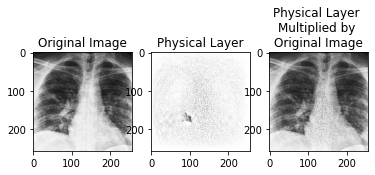

In [68]:
# Maybe visualize the top filter?
plt.subplot(1, 3, 1)
plt.imshow(new_covid_im2, cmap="gray")
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(test_mod_2.layers[2].get_weights()[0][:, :, 0], cmap="gray")
plt.title("Physical Layer")
plt.subplot(1, 3, 3)
plt.imshow(new_covid_im2*test_mod_2.layers[2].get_weights()[0][:, :, 0], cmap="gray")
plt.title("Physical Layer \nMultiplied by \nOriginal Image")
plt.show()

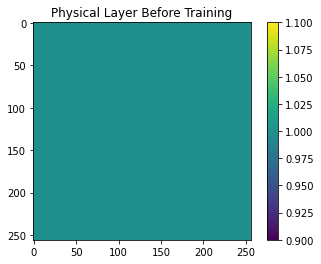

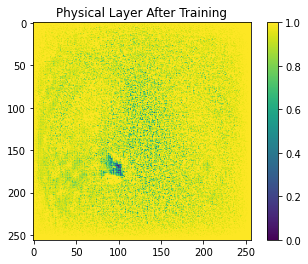

In [69]:
plt.imshow(pl_before_train)
plt.title("Physical Layer Before Training")
plt.colorbar()
plt.show()
plt.imshow(test_mod_2.layers[2].get_weights()[0][:, :, 0])
plt.title("Physical Layer After Training")
plt.colorbar()
plt.show()

In [70]:
# Print metrics
# Iterate through all of the test datasets, find % of false + and false -
cov_neg = 0
cov_pos = 0
results = list()
for i in range(352):
    result = test_mod_2.predict(np.reshape(
        x_test[i][:, :], 
        (1, 256, 256, 1)
        )
    )
    results.append(result[0])
    cov_neg += result[0][0]
    cov_pos += result[0][1]
print("Total COVID Negative Score: {}\nTotal COVID Positive Score: {}".format(cov_neg, cov_pos))
# Sanity check, should generally be pretty close

Total COVID Negative Score: 177.51788892219065
Total COVID Positive Score: 174.4821105331077


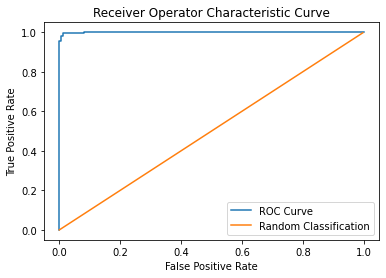

AUC Score: 0.999


In [71]:
# Not really needed, useful to have, may use
y_te = np.zeros((len(y_test), 2))
for i, y in enumerate(y_test):
    if y == 0:
        y_te[i,:] = [1,0]
    else:
        y_te[i,:] = [0,1]

y_pred = test_mod_2.predict(x_test).ravel()
# Only include the positive labels - from 
neg_labels = np.arange(0, len(y_pred), 2)
y_pred = np.delete(y_pred, neg_labels)


fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
# prec, rec, threshs = precision_recall_curve(y_test, y_pred)
plt.plot(fpr_keras, tpr_keras)
plt.plot(np.arange(0,1,1/352), np.arange(0,1,1/352))
plt.title("Receiver Operator Characteristic Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["ROC Curve", "Random Classification"])
plt.show()

pl_auc = roc_auc_score(y_test, y_pred)
print("AUC Score: {0:0.3f}".format(pl_auc))

In [72]:
# Make a confusion matrix
y_pred2 = test_mod_2.predict(x_test)

## Uncomment these lines of code to see how comparisons stack up vs reality
# for pred, te in zip(y_pred2, y_te):
#     print("Prediction: {0:0.5f}, {1:0.5f}\n      True: {2:0.5f}, {3:0.5f}\n".format(pred[0], pred[1], te[0], te[1]))


# Get the maximum locations
y_te_cm = y_te.argmax(axis=1)
y_pred_cm = y_pred2.argmax(axis=1)
cm = confusion_matrix(y_te_cm, y_pred_cm)
# 0,0 is true negatives
# 1,0 is false negatives
# 1,1 is true positives
# 0,1 is false positives
print(cm)

[[174   2]
 [  1 175]]


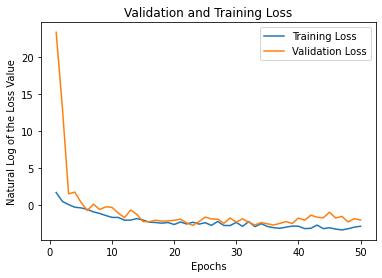

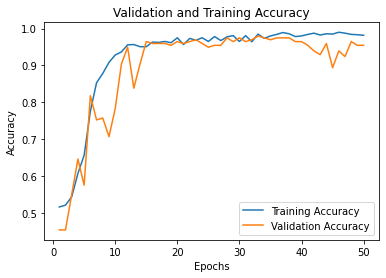

In [73]:
plt.plot(np.arange(1,51,1), np.log(loss_and_acc.history["loss"]))
plt.plot(np.arange(1,51,1), np.log(loss_and_acc.history["val_loss"]))
plt.ylabel("Natural Log of the Loss Value")
plt.xlabel("Epochs")
plt.title("Validation and Training Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

plt.plot(np.arange(1,51,1), loss_and_acc.history["acc"])
plt.plot(np.arange(1,51,1), loss_and_acc.history["val_acc"])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Validation and Training Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])

plt.show()

In [74]:
# Train the model without the physical layer
opt = tf.keras.optimizers.SGD(learning_rate=0.85)
test_mod.compile(loss="categorical_crossentropy", 
                 metrics=['acc'], 
                 optimizer=opt)
loss_and_acc = test_mod.fit(mod_data.flow(x_train, y_train, batch_size=32), epochs=50, validation_data=(x_val, y_val), validation_batch_size=32)

Epoch 1/50
38/38 [==============================] - 8s 208ms/step - loss: 5.2117 - acc: 0.4700 - val_loss: 2129433728.0000 - val_acc: 0.5455
Epoch 2/50
38/38 [==============================] - 7s 176ms/step - loss: 1.3972 - acc: 0.5258 - val_loss: 3020682752.0000 - val_acc: 0.4545
Epoch 3/50
38/38 [==============================] - 7s 178ms/step - loss: 0.7388 - acc: 0.5825 - val_loss: 30747.2188 - val_acc: 0.5455
Epoch 4/50
38/38 [==============================] - 7s 178ms/step - loss: 1.0591 - acc: 0.5875 - val_loss: 54548.5117 - val_acc: 0.4545
Epoch 5/50
38/38 [==============================] - 7s 178ms/step - loss: 0.6874 - acc: 0.6958 - val_loss: 3356.6475 - val_acc: 0.4545
Epoch 6/50
38/38 [==============================] - 7s 175ms/step - loss: 0.5086 - acc: 0.8242 - val_loss: 50.1621 - val_acc: 0.4798
Epoch 7/50
38/38 [==============================] - 7s 178ms/step - loss: 0.4605 - acc: 0.8892 - val_loss: 0.9808 - val_acc: 0.4545
Epoch 8/50
38/38 [============================

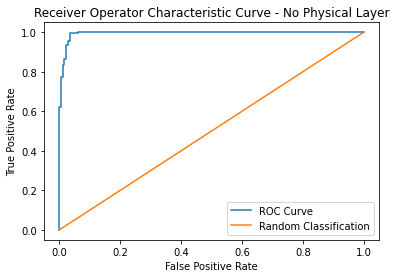

In [75]:
y_te = np.zeros((len(y_test), 2))
for i, y in enumerate(y_test):
    if y == 0:
        y_te[i,:] = [1,0]
    else:
        y_te[i,:] = [0,1]

y_pred_no_pl = test_mod.predict(x_test).ravel()
# Only include the positive labels
neg_labels = np.arange(0, len(y_pred_no_pl), 2)
y_pred_no_pl = np.delete(y_pred_no_pl, neg_labels)
# y_te.resize(704)  # Used this initially, switched to y_test
fpr_keras_no_pl, tpr_keras_no_pl, thresholds_keras_no_pl = roc_curve(y_test, y_pred_no_pl)
plt.plot(fpr_keras_no_pl, tpr_keras_no_pl)
plt.plot(np.arange(0,1,1/352), np.arange(0,1,1/352))
plt.title("Receiver Operator Characteristic Curve - No Physical Layer")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["ROC Curve", "Random Classification"])
plt.show()

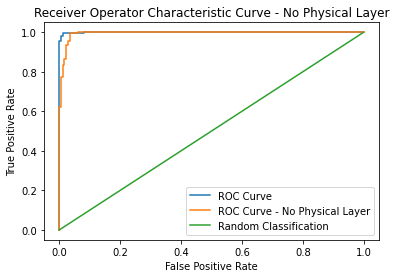

In [76]:
# Overlay the 2 ROC Curves
plt.plot(fpr_keras, tpr_keras)
plt.plot(fpr_keras_no_pl, tpr_keras_no_pl)
plt.plot(np.arange(0,1,1/352), np.arange(0,1,1/352))
plt.title("Receiver Operator Characteristic Curve - No Physical Layer")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["ROC Curve", "ROC Curve - No Physical Layer", "Random Classification"])
plt.show()